<a href="https://colab.research.google.com/github/ekvirika/Facial-Expression-Recognition/blob/main/notebooks/02_simple_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 81% 231M/285M [00:00<00:00, 449MB/s]
100% 285M/285M [00:00<00:00, 465MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import wandb
import time
from datetime import datetime
from sklearn.model_selection import train_test_split

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
CONFIG = {
    'model_name': 'simple_cnn',
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'image_size': 48,
    'num_classes': 7,
    'random_seed': 42,
    'early_stop_patience': 5,  # More aggressive early stopping

}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])


Using device: cuda


In [90]:
# Initialize wandb
wandb.init(
    project="facial-expression-recognition",
    name=f"{CONFIG['model_name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    config=CONFIG,
    job_type="training"
)

# Custom Dataset Class

In [76]:
class FERDataset(Dataset):
    def __init__(self, dataframe, indices, transform=None):
        self.data = dataframe.iloc[indices].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      # Get the actual index from your subset
      actual_idx = self.indices[idx] if hasattr(self, 'indices') else idx

      # Load image (assuming pixels are stored as string)
      pixels = self.data.iloc[actual_idx]['pixels']
      image = np.array([int(x) for x in pixels.split()]).reshape(48, 48)

      # Convert to PIL Image (grayscale)
      image = Image.fromarray(image.astype(np.uint8), mode='L')

      # Apply transforms (this will convert to tensor)
      if self.transform:
          image = self.transform(image)

      # Get label
      label = self.data.iloc[actual_idx]['emotion']

      return image, label

#  Define Simple CNN Model


In [77]:
class SimpleCNN(nn.Module):
        def __init__(self, num_classes=7):
            super(SimpleCNN, self).__init__()

            # Feature extraction layers
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32) # Add BatchNorm

            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64) # Add BatchNorm

            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128) # Add BatchNorm

            self.pool = nn.MaxPool2d(2, 2)
            self.dropout = nn.Dropout(0.5)

            self.fc1 = nn.Linear(128 * 6 * 6, 512)
            self.fc2 = nn.Linear(512, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Apply BatchNorm
            x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Apply BatchNorm
            x = self.pool(F.relu(self.bn3(self.conv3(x)))) # Apply BatchNorm

            x = x.view(x.size(0), -1)

            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)

            return x

# Load data

In [87]:
# Load data
from PIL import Image

print("Loading data...")
train_df = pd.read_csv('train.csv')
train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['emotion'],
    random_state=42
)

# Add data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor - ADD THIS FIRST
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor - ADD THIS FIRST
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_df, train_indices, transform=train_transform)
val_dataset = FERDataset(train_df, val_indices, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    # sampler=sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loading data...
Training samples: 22967
Validation samples: 5742


# Training

## Initialize model


In [91]:
model = SimpleCNN(num_classes=CONFIG['num_classes']).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Parameters: {total_params:,} total, {trainable_params:,} trainable")

# Log model info
wandb.log({
    "model_parameters": total_params,
    "trainable_parameters": trainable_params
})


Model Parameters: 2,456,519 total, 2,456,519 trainable


In [92]:

# Define loss and optimizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class weights from training data
labels = train_df['emotion'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer =optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)

## Training Function

In [80]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


## Validation function

In [81]:
# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_targets


## Training Loop

In [93]:
print("\nStarting training...")
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
patience_counter = 0
early_stop_patience = CONFIG['early_stop_patience']

start_time = time.time()

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start

    # Log to wandb
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'epoch_time': epoch_time,
        'learning_rate': optimizer.param_groups[0]['lr']
    })

    print(f'Epoch [{epoch+1}/{CONFIG["epochs"]}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')
    print('-' * 50)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'simple_cnn_best.pth')
        print(f'New best validation accuracy: {best_val_acc:.2f}%')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f}s')
print(f'Best validation accuracy: {best_val_acc:.2f}%')


Starting training...
Batch 0/718, Loss: 1.9746
Batch 100/718, Loss: 1.9201
Batch 200/718, Loss: 2.0033
Batch 300/718, Loss: 1.9417
Batch 400/718, Loss: 1.8943
Batch 500/718, Loss: 1.9288
Batch 600/718, Loss: 1.8682
Batch 700/718, Loss: 1.9413
Epoch [1/20]
Train Loss: 1.9805, Train Acc: 16.95%
Val Loss: 1.9125, Val Acc: 21.47%
Time: 49.96s
--------------------------------------------------
New best validation accuracy: 21.47%
Batch 0/718, Loss: 1.8882
Batch 100/718, Loss: 1.9032
Batch 200/718, Loss: 1.9440
Batch 300/718, Loss: 1.8536
Batch 400/718, Loss: 1.6705
Batch 500/718, Loss: 1.7606
Batch 600/718, Loss: 1.9015
Batch 700/718, Loss: 2.0056
Epoch [2/20]
Train Loss: 1.8898, Train Acc: 23.45%
Val Loss: 1.8257, Val Acc: 26.85%
Time: 47.86s
--------------------------------------------------
New best validation accuracy: 26.85%
Batch 0/718, Loss: 1.7331
Batch 100/718, Loss: 1.7481
Batch 200/718, Loss: 2.0202
Batch 300/718, Loss: 1.7542
Batch 400/718, Loss: 1.9874
Batch 500/718, Loss: 1.6

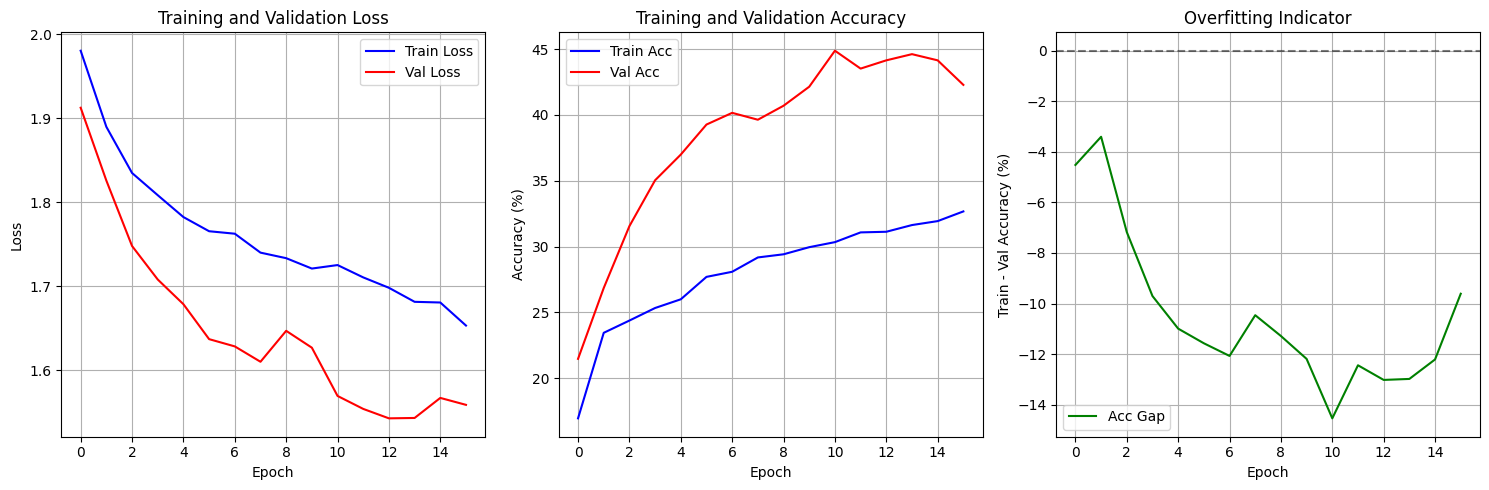

In [94]:

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc', color='blue')
plt.plot(val_accs, label='Val Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(np.array(train_accs) - np.array(val_accs), label='Acc Gap', color='green')
plt.xlabel('Epoch')
plt.ylabel('Train - Val Accuracy (%)')
plt.title('Overfitting Indicator')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('simple_cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## load bst model

In [95]:

# Load best model for final evaluation
model.load_state_dict(torch.load('simple_cnn_best.pth'))

# Final validation with best model
final_val_loss, final_val_acc, final_preds, final_targets = validate_epoch(
    model, val_loader, criterion, device
)

print(f'Final validation accuracy: {final_val_acc:.2f}%')

# Classification report
expression_mapping = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

class_names = [expression_mapping[i] for i in range(7)]
class_report = classification_report(
    final_targets, final_preds,
    target_names=class_names,
    output_dict=True
)

print("\nClassification Report:")
print(classification_report(final_targets, final_preds, target_names=class_names))


Final validation accuracy: 44.88%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.37      0.20      0.26       799
     Disgust       0.54      0.16      0.25        87
        Fear       0.23      0.13      0.17       820
       Happy       0.68      0.78      0.73      1443
         Sad       0.29      0.51      0.37       966
    Surprise       0.62      0.73      0.67       634
     Neutral       0.31      0.21      0.25       993

    accuracy                           0.45      5742
   macro avg       0.43      0.39      0.38      5742
weighted avg       0.43      0.45      0.43      5742



##  Confusion Matrix

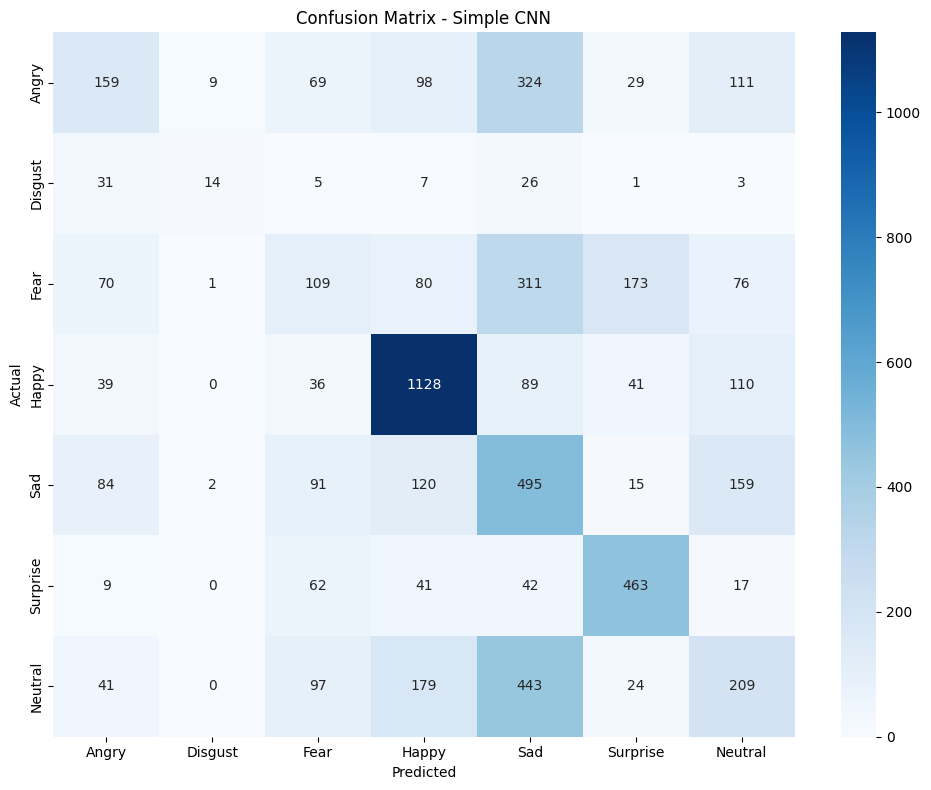

Angry: 19.9% (799 samples)
Disgust: 16.1% (87 samples)
Fear: 13.3% (820 samples)
Happy: 78.2% (1443 samples)
Sad: 51.2% (966 samples)
Surprise: 73.0% (634 samples)
Neutral: 21.0% (993 samples)


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Simple CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('simple_cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze per-class performance
per_class_acc = []
for i in range(7):
    class_mask = np.array(final_targets) == i
    if class_mask.sum() > 0:
        class_acc = (np.array(final_preds)[class_mask] == i).mean() * 100
        per_class_acc.append(class_acc)
        print(f'{class_names[i]}: {class_acc:.1f}% ({class_mask.sum()} samples)')

# Log final results to wandb
wandb.log({
    'final_val_accuracy': final_val_acc,
    'final_val_loss': final_val_loss,
    'training_curves': wandb.Image('simple_cnn_training_curves.png'),
    'confusion_matrix': wandb.Image('simple_cnn_confusion_matrix.png'),
    'classification_report': class_report,
    'total_training_time': total_time,
    'best_epoch': np.argmax(val_accs) + 1
})

# Analyzis

In [97]:

# Analysis of results
print("\n" + "="*60)
print("SIMPLE CNN BASELINE ANALYSIS")
print("="*60)

# Check for overfitting/underfitting
final_train_acc = train_accs[-1]
acc_gap = final_train_acc - final_val_acc

print(f"\nOverfitting Analysis:")
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Accuracy Gap: {acc_gap:.2f}%")

if acc_gap > 10:
    print("🔴 OVERFITTING DETECTED: Large gap between train and validation accuracy")
    print("   - Model memorizing training data")
    print("   - Need regularization (dropout, data augmentation)")
elif acc_gap < 5:
    print("🟡 GOOD GENERALIZATION: Small gap between train and validation")
    if final_val_acc < 50:
        print("🔴 UNDERFITTING: Both accuracies are low")
        print("   - Model too simple for the task")
        print("   - Need more capacity or different architecture")
    else:
        print("✅ BALANCED MODEL: Good generalization")
else:
    print("🟡 MILD OVERFITTING: Moderate gap, could be improved")

# Learning curve analysis
print(f"\nLearning Curve Analysis:")
print(f"Best epoch: {np.argmax(val_accs) + 1}")
print(f"Early stopping could have saved {CONFIG['epochs'] - np.argmax(val_accs) - 1} epochs")

if val_accs[-1] < max(val_accs) * 0.95:
    print("🔴 VALIDATION ACCURACY DECLINING: Clear overfitting in later epochs")
else:
    print("✅ STABLE LEARNING: No significant decline in validation performance")

# Performance insights
worst_class = class_names[np.argmin(per_class_acc)]
best_class = class_names[np.argmax(per_class_acc)]

print(f"\nPer-class Performance:")
print(f"Best performing class: {best_class} ({max(per_class_acc):.1f}%)")
print(f"Worst performing class: {worst_class} ({min(per_class_acc):.1f}%)")
print(f"Performance variance: {np.std(per_class_acc):.1f}%")

# Model complexity analysis
print(f"\nModel Complexity:")
print(f"Total parameters: {total_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (float32)")
print(f"Training time: {total_time:.1f}s ({total_time/CONFIG['epochs']:.1f}s/epoch)")

# Recommendations for next experiments
print(f"\n🔬 RECOMMENDATIONS FOR NEXT EXPERIMENTS:")
print(f"1. Architecture: Try deeper CNN with more layers")
print(f"2. Regularization: Add batch normalization, more dropout")
print(f"3. Data: Implement data augmentation to reduce overfitting")
print(f"4. Optimization: Try different learning rates, schedulers")
print(f"5. Loss: Consider weighted loss for class imbalance")

# Save experiment summary
experiment_summary = {
    'model_name': CONFIG['model_name'],
    'final_val_accuracy': final_val_acc,
    'best_val_accuracy': best_val_acc,
    'final_train_accuracy': final_train_acc,
    'overfitting_gap': acc_gap,
    'total_parameters': total_params,
    'training_time': total_time,
    'best_epoch': int(np.argmax(val_accs) + 1),
    'per_class_accuracy': dict(zip(class_names, per_class_acc)),
    'key_findings': {
        'overfitting_detected': acc_gap > 10,
        'underfitting_detected': final_val_acc < 40,
        'early_stopping_beneficial': val_accs[-1] < max(val_accs) * 0.95,
        'class_imbalance_impact': max(per_class_acc) - min(per_class_acc) > 20
    }
}

# Log summary
wandb.log({'experiment_summary': experiment_summary})

print(f"\n✅ Simple CNN baseline complete!")
print(f"📊 Results logged to Wandb")
print(f"💾 Best model saved as 'simple_cnn_best.pth'")

wandb.finish()


SIMPLE CNN BASELINE ANALYSIS

Overfitting Analysis:
Final Training Accuracy: 32.67%
Final Validation Accuracy: 44.88%
Accuracy Gap: -12.21%
🟡 GOOD GENERALIZATION: Small gap between train and validation
🔴 UNDERFITTING: Both accuracies are low
   - Model too simple for the task
   - Need more capacity or different architecture

Learning Curve Analysis:
Best epoch: 11
Early stopping could have saved 9 epochs
🔴 VALIDATION ACCURACY DECLINING: Clear overfitting in later epochs

Per-class Performance:
Best performing class: Happy (78.2%)
Worst performing class: Fear (13.3%)
Performance variance: 26.0%

Model Complexity:
Total parameters: 2,456,519
Model size: ~9.4 MB (float32)
Training time: 780.5s (39.0s/epoch)

🔬 RECOMMENDATIONS FOR NEXT EXPERIMENTS:
1. Architecture: Try deeper CNN with more layers
2. Regularization: Add batch normalization, more dropout
3. Data: Implement data augmentation to reduce overfitting
4. Optimization: Try different learning rates, schedulers
5. Loss: Consider we

best_epoch,▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_time,▇▂█▂▂▂▇▃▄▄▄▆▁▂▃▇
final_val_accuracy,▁
final_val_loss,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_parameters,▁
total_training_time,▁
train_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▁
trainable_parameters,▁
